## Regression Assignment
### Gowlapalli Rohit 2021101113

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  
warnings.filterwarnings("ignore")
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
import statsmodels.api as sm
from scipy.stats import pearsonr
from scipy.stats import bartlett
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip

# Question 1

In [107]:
df = pd.read_csv("housing.csv")
counts = df['ocean_proximity'].value_counts()

#### We can see that ocean_proximity is having string variables. Lets convert it to numericals before we perform the correlation analysis

In [108]:
# cleaning the data by removing the nan values and changing data to numerical variables
df['ocean_proximity'] = df['ocean_proximity'].map({'<1H OCEAN':0, 'INLAND':1, 'NEAR OCEAN':2, 'NEAR BAY':3, 'ISLAND':4})
df = df.dropna()

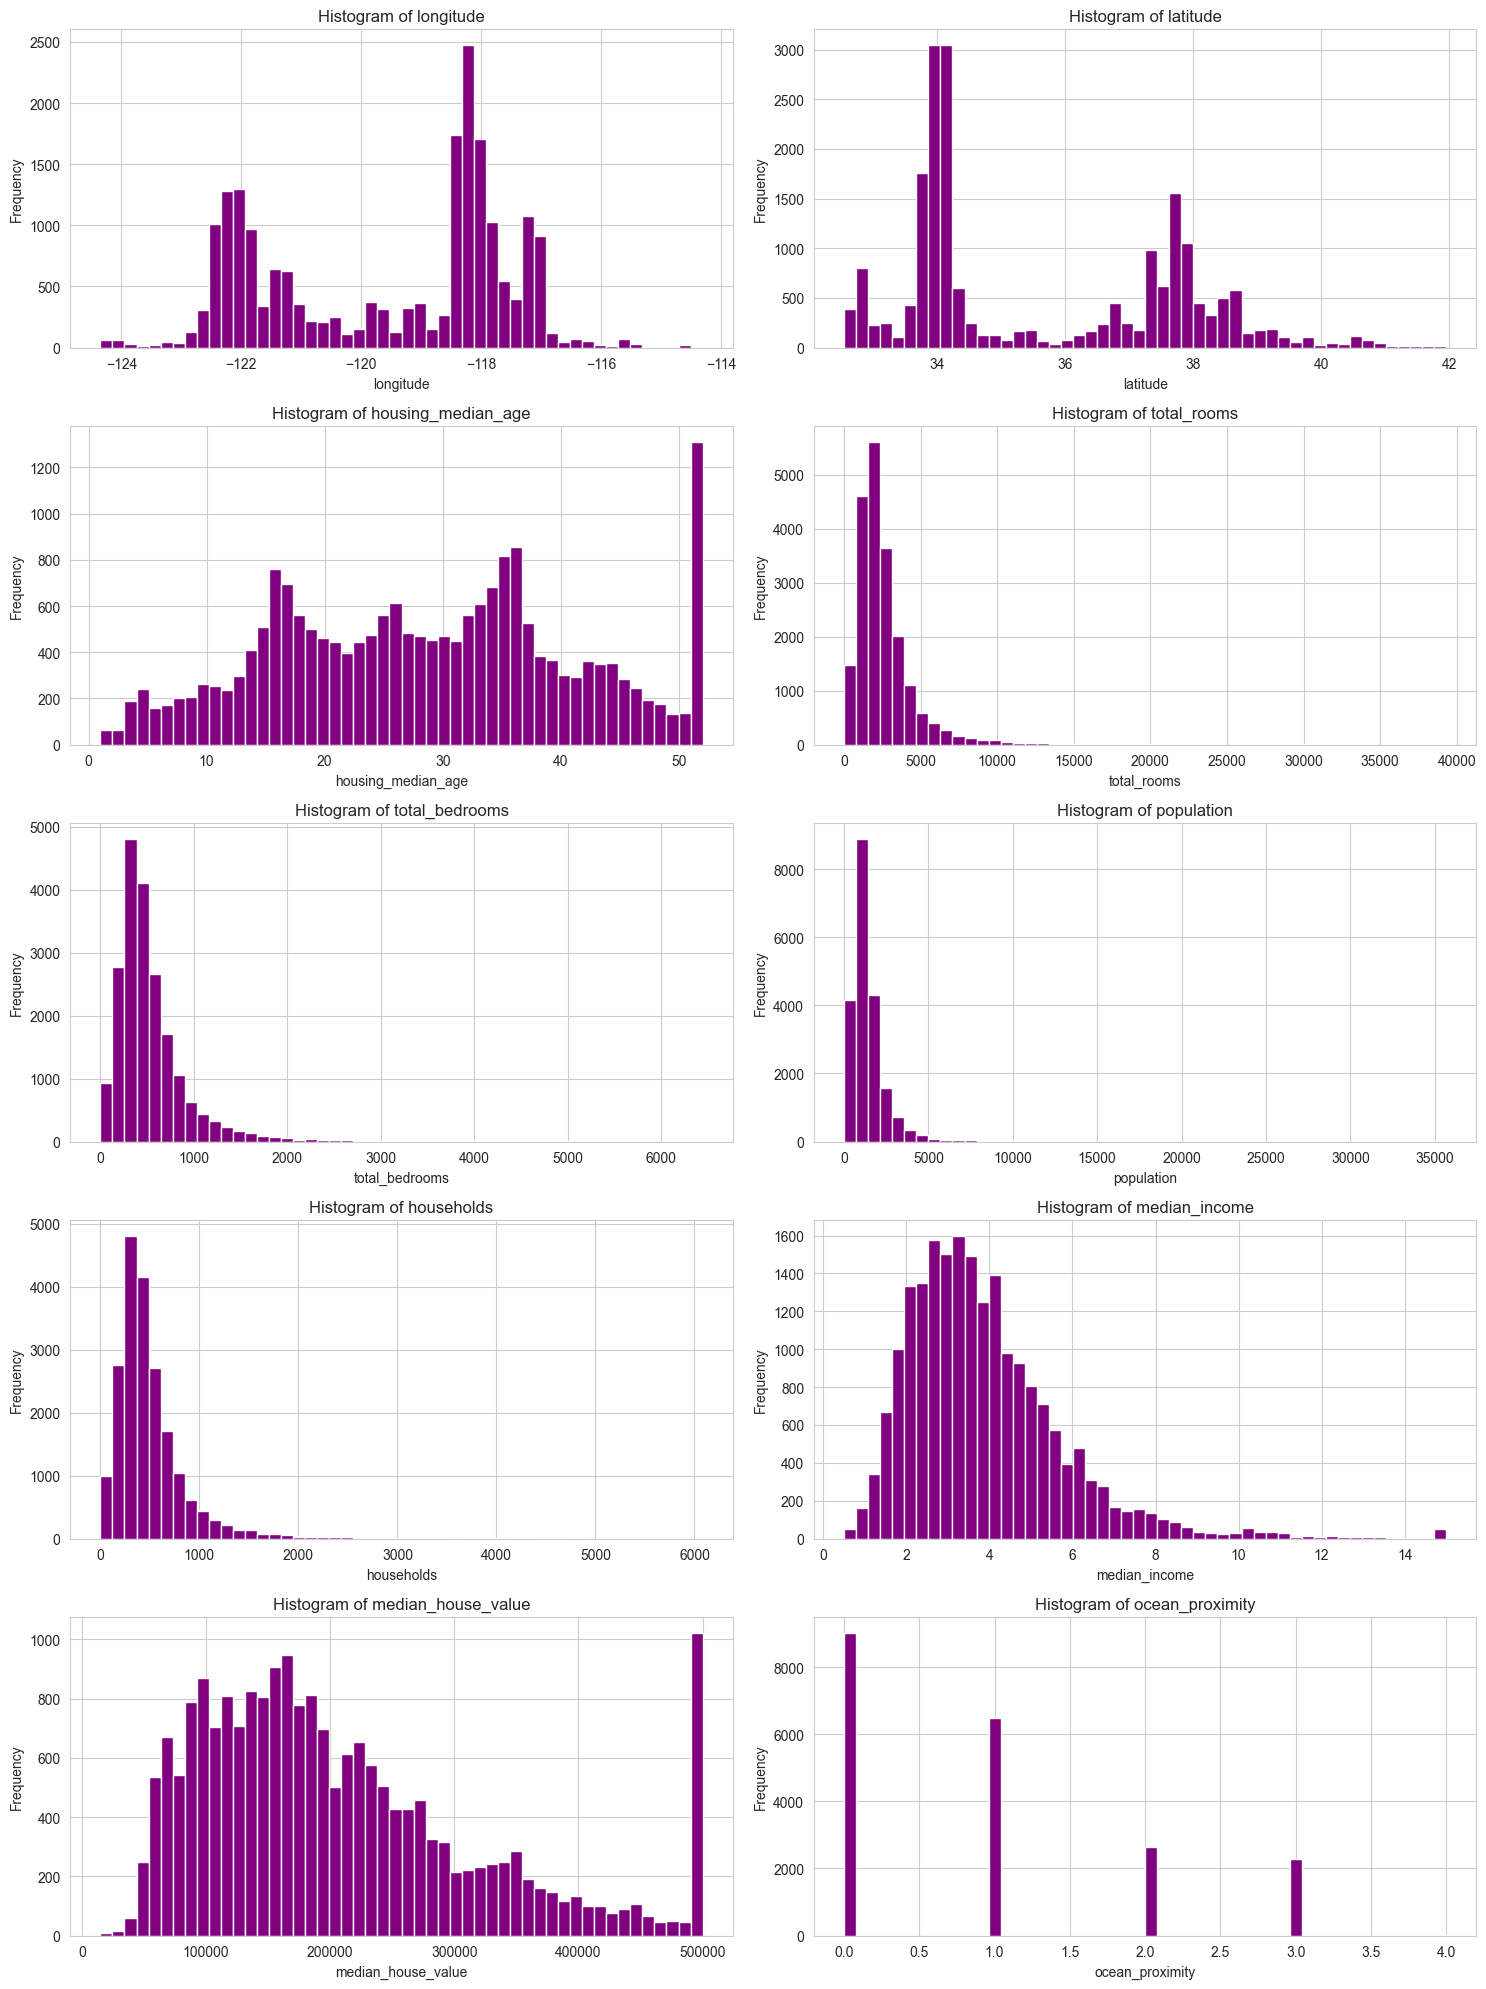

In [109]:
numeric_cols = df.columns
num_rows = 5
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))
axes = axes.flatten()
for i, col_name in enumerate(numeric_cols):
    axes[i].hist(df[col_name], bins=50, color='purple')
    axes[i].set_title(f'Histogram of {col_name}')
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

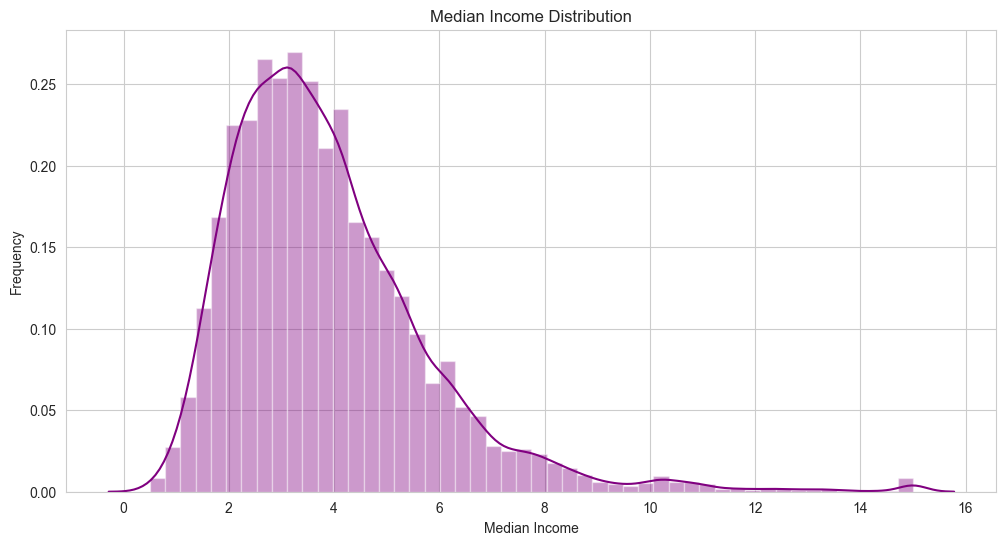

In [110]:
df_1 = df['median_income']
df_1 = np.array(pd.DataFrame(df_1, columns=['median_income'])).reshape(-1, 1)
y = df['median_house_value']
df_2 = df.copy()
df_2 = df_2.drop('median_house_value', axis=1)

plt.figure(figsize=(12, 6))
sns.distplot(df['median_income'], bins=50, color='purple')
plt.title('Median Income Distribution')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.show()

<Axes: >

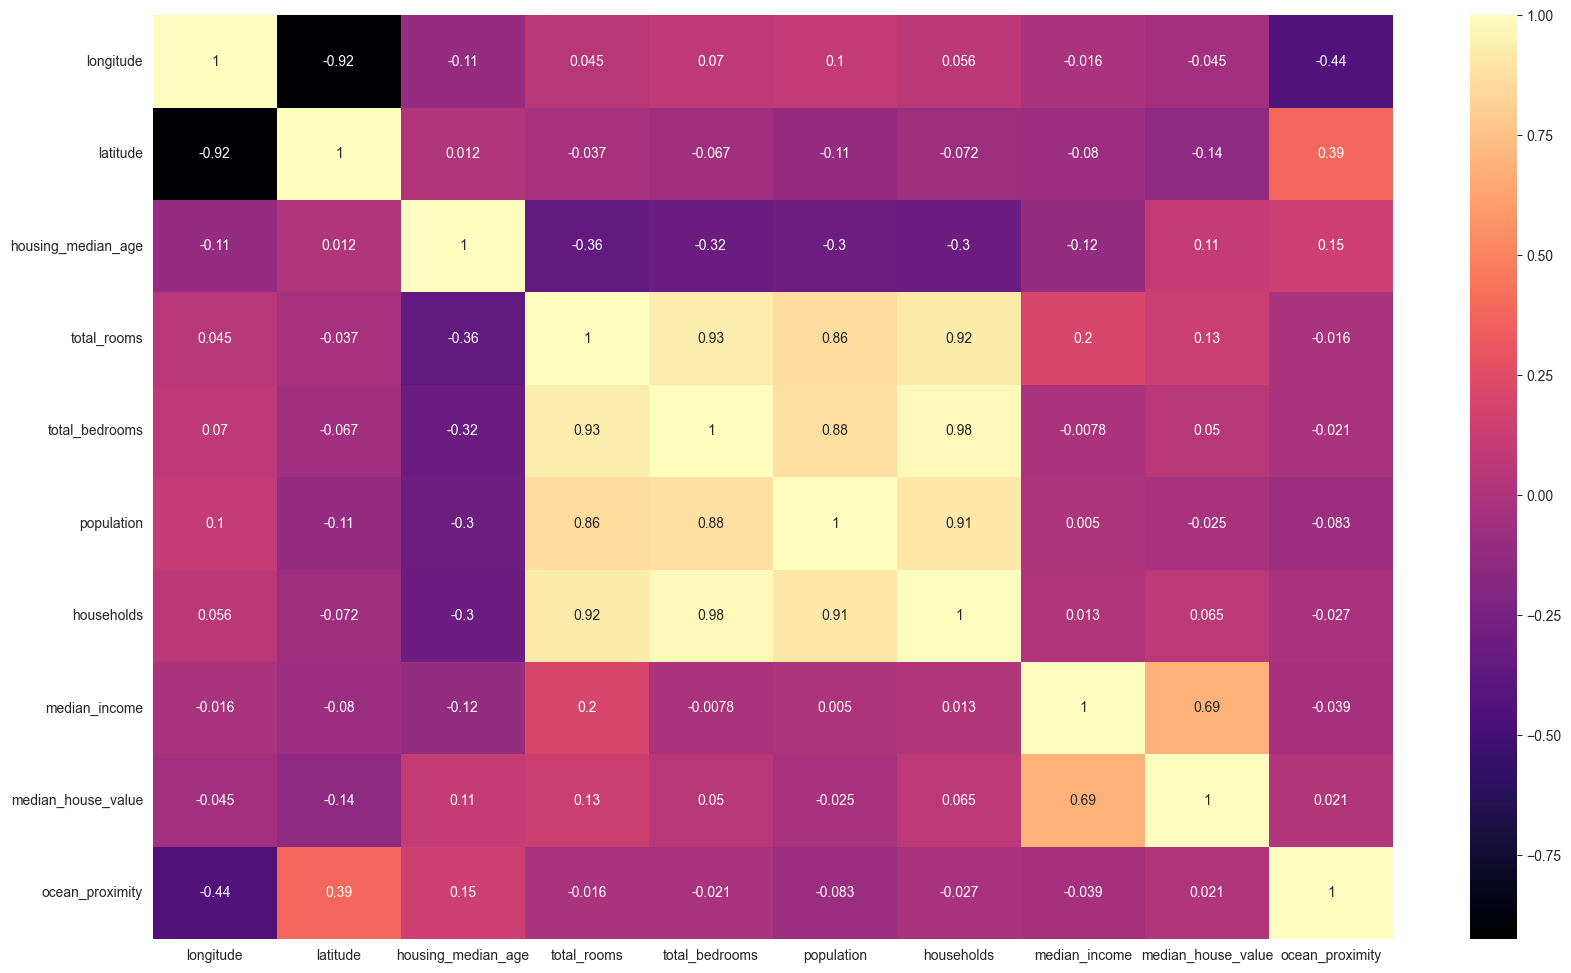

In [111]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True, cmap='magma')

#### We can clearly see some of the variables are highly correlated, now lets perform a correlation test to confirm the collinearity before building the model

In [112]:
def correlation_test(data1, data2, alternative):
    corr, p_value = pearsonr(data1, data2)
    print("Correlation coefficient:", corr)
    print("p-value:", p_value)
    print("Alternative hypothesis:", alternative)
    if alternative == "greater":
        if p_value/2 < 0.05:
            print("Reject the null hypothesis: There is a positive correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no positive correlation between the two variables")
    elif alternative == "less":
        if p_value/2 < 0.05:
            print("Reject the null hypothesis: There is a negative correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no negative correlation between the two variables")
    else:
        if p_value < 0.05:
            print("Reject the null hypothesis: There is a correlation between the two variables")
        else:
            print("Fail to reject the null hypothesis: There is no correlation between the two variables")

print("Correlation test for total_bedrooms and total_rooms:")
correlation_test(df['total_bedrooms'], df['total_rooms'], alternative="greater")
print("\nCorrelation test for households and population:")
correlation_test(df['households'], df['population'], alternative="greater")
print("\nCorrelation test for longitude and latitude:")
correlation_test(df['longitude'], df['latitude'], alternative="less")

Correlation test for total_bedrooms and total_rooms:
Correlation coefficient: 0.930377047611133
p-value: 0.0
Alternative hypothesis: greater
Reject the null hypothesis: There is a positive correlation between the two variables

Correlation test for households and population:
Correlation coefficient: 0.9071823610456953
p-value: 0.0
Alternative hypothesis: greater
Reject the null hypothesis: There is a positive correlation between the two variables

Correlation test for longitude and latitude:
Correlation coefficient: -0.9246131238737124
p-value: 0.0
Alternative hypothesis: less
Reject the null hypothesis: There is a negative correlation between the two variables


##### Based on the correlation tests conducted earlier, it's evident that whenever the p-value falls below 0.05, indicating a significant correlation, utilizing just one of the variables from the correlated pair is adequate for model construction.

##### We constructed three linear regression models by selecting only one variable from each highly correlated pair, effectively reducing the dimensions by three in each model. In the third model, we employed only two variables with notably high absolute correlation values. Notably, in all cases, the p-value was below 0.05, indicating a strong fit of the model to the data.

### Method 1 : Model 1 - Linear Regression

In [113]:
f1 = 'median_house_value ~ longitude + housing_median_age + total_rooms + households + median_income + ocean_proximity'
model = sm.formula.ols(formula=f1, data=df)
result = model.fit()
r1 = result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     3968.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:57:19   Log-Likelihood:            -2.5926e+05
No. Observations:               20432   AIC:                         5.185e+05
Df Residuals:                   20425   BIC:                         5.186e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.134e+05   3.63

In [114]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
features = ['longitude', 'housing_median_age', 'total_rooms', 'households', 'median_income', 'ocean_proximity']
X = df[features]
vif_data_f1 = pd.DataFrame()
vif_data_f1["Feature"] = X.columns
vif_data_f1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data_f1)

              Feature        VIF
0           longitude  17.077745
1  housing_median_age   7.320093
2         total_rooms  21.136321
3          households  21.646955
4       median_income   6.654595
5     ocean_proximity   1.889437



##### To address collinearity, we utilized the Variance Inflation Factor (VIF) to detect multicollinearity. A VIF value above 5 suggests significant multicollinearity within the model, indicating the need for further adjustments.

##### A VIF exceeding 5 presents a potential issue. Therefore, in our scenario, we could address multicollinearity by eliminating either 'total_rooms' or 'households', as they exhibit high correlation with each other.

In [115]:
f1_modified = 'median_house_value ~ longitude + housing_median_age + households + median_income + ocean_proximity'
model_modified = sm.formula.ols(formula=f1_modified, data=df)
result_modified = model_modified.fit()
print(result_modified.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     4500.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:57:19   Log-Likelihood:            -2.5957e+05
No. Observations:               20432   AIC:                         5.192e+05
Df Residuals:                   20426   BIC:                         5.192e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.094e+05   3.69

In [116]:
features_modified = ['longitude', 'housing_median_age', 'households', 'median_income', 'ocean_proximity']
X_modified = df[features_modified]
vif_data_f1_modified = pd.DataFrame()
vif_data_f1_modified["Feature"] = X_modified.columns
vif_data_f1_modified["VIF"] = [variance_inflation_factor(X_modified.values, i) for i in range(len(X_modified.columns))]
print(vif_data_f1_modified)

              Feature        VIF
0           longitude  16.775420
1  housing_median_age   7.043675
2          households   2.972707
3       median_income   5.242511
4     ocean_proximity   1.877785


### Check for homodatasticity

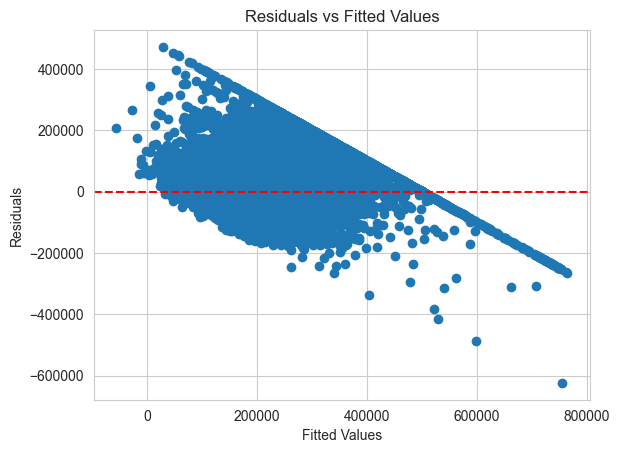

In [117]:
my_resid = result.resid
my_fitted = result.fittedvalues

# Create scatter plot
plt.scatter(my_fitted, my_resid)
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

#### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

In [118]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)
if lm_p_value < 0.05:
    print("Reject the null hypothesis: The residuals are heteroscedastic")
else:
    print("Fail to reject the null hypothesis: The residuals are homoscedastic")

Lagrange multiplier statistic: 524.671115578385
p-value for Lagrange multiplier test: 4.065464026424511e-110
F-statistic: 89.71911465291723
p-value for F-statistic: 1.4456207494871716e-111
Reject the null hypothesis: The residuals are heteroscedastic


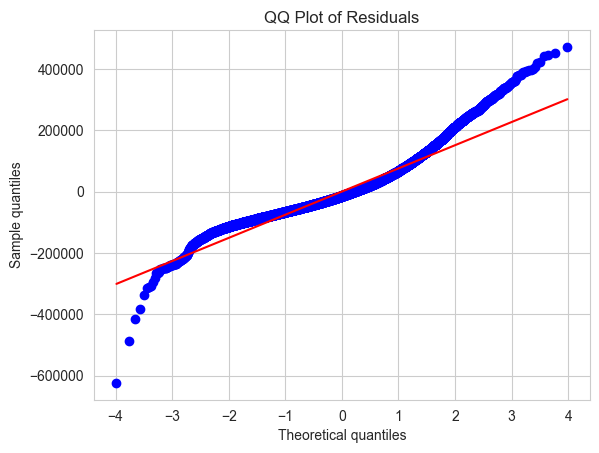

The QQ plot shows that the residuals are not normally distributed as there is significant deviation from the straight line
Shapiro-Wilk test statistic: 0.9272869184272368
Shapiro-Wilk test p-value: 2.2114817119513993e-70
Reject the null hypothesis: The residuals are not normally distributed


In [119]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()
print("The QQ plot shows that the residuals are not normally distributed as there is significant deviation from the straight line")

# perform shapiro-wilk test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("Shapiro-Wilk test p-value:", shapiro_test[1])
if shapiro_test[1] < 0.05:
    print("Reject the null hypothesis: The residuals are not normally distributed")
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed")

### Method 2 : Model 2 - Linear Regression

In [120]:
f2 = 'median_house_value ~ latitude + housing_median_age + total_bedrooms + population + median_income + ocean_proximity'
model = sm.formula.ols(formula=f2, data=df)
result = model.fit()
r2 = result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     4331.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:57:20   Log-Likelihood:            -2.5877e+05
No. Observations:               20432   AIC:                         5.176e+05
Df Residuals:                   20425   BIC:                         5.176e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.898e+05   1.01

In [121]:
features_r2 = ['latitude', 'housing_median_age', 'total_bedrooms', 'population', 'median_income', 'ocean_proximity']
X_r2 = df[features_r2]
vif_data_f2 = pd.DataFrame()
vif_data_f2["Feature"] = X_r2.columns
vif_data_f2["VIF"] = [variance_inflation_factor(X_r2.values, i) for i in range(len(X_r2.columns))]
print(vif_data_f2)

              Feature        VIF
0            latitude  16.080084
1  housing_median_age   6.769862
2      total_bedrooms  11.855788
3          population  11.424839
4       median_income   5.053573
5     ocean_proximity   1.958505


##### To address collinearity, we utilized the Variance Inflation Factor (VIF) to detect multicollinearity. A VIF value above 5 suggests significant multicollinearity within the model, indicating the need for further adjustments.

##### A VIF exceeding 5 presents a potential issue. Therefore, in our scenario, we could address multicollinearity by eliminating 'latitude' and 'total_bedrooms', as they exhibit high correlation with each other.

In [122]:
# remove total_bedrooms and latitude from the model
f2_modified = 'median_house_value ~ housing_median_age + population + median_income + ocean_proximity'
model_modified = sm.formula.ols(formula=f2_modified, data=df)
result_modified = model_modified.fit()
print(result_modified.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     5336.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:57:20   Log-Likelihood:            -2.5985e+05
No. Observations:               20432   AIC:                         5.197e+05
Df Residuals:                   20427   BIC:                         5.197e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.925e+04   2293

In [123]:
features_modified_r2 = ['housing_median_age', 'population', 'median_income', 'ocean_proximity']
X_modified_r2 = df[features_modified_r2]
vif_data_f2_modified = pd.DataFrame()
vif_data_f2_modified["Feature"] = X_modified_r2.columns
vif_data_f2_modified["VIF"] = [variance_inflation_factor(X_modified_r2.values, i) for i in range(len(X_modified_r2.columns))]
print(vif_data_f2_modified)

              Feature       VIF
0  housing_median_age  3.343390
1          population  2.060318
2       median_income  3.398675
3     ocean_proximity  1.803963


### Check for homodatasticity

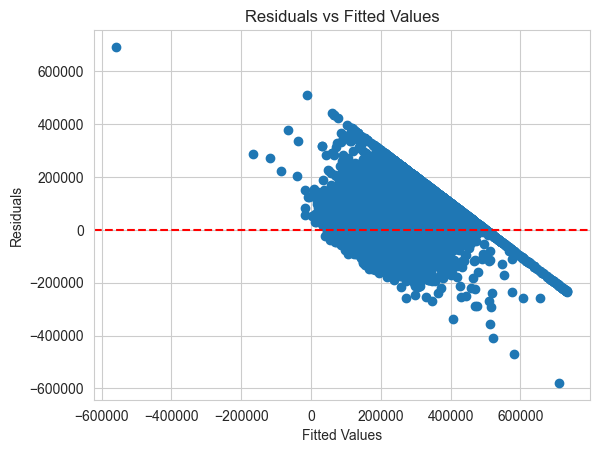

In [124]:
my_resid = result.resid
my_fitted = result.fittedvalues
plt.scatter(my_fitted, my_resid)
plt.title("Residuals vs Fitted Values")
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

#### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

In [125]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)
if f_p_value < 0.05:
    print("Reject the null hypothesis: The residuals are heteroscedastic")
else:
    print("Fail to reject the null hypothesis: The residuals are homoscedastic")

Lagrange multiplier statistic: 530.6990859553763
p-value for Lagrange multiplier test: 2.0419154123841378e-111
F-statistic: 90.77738918890613
p-value for F-statistic: 6.710276783079889e-113
Reject the null hypothesis: The residuals are heteroscedastic


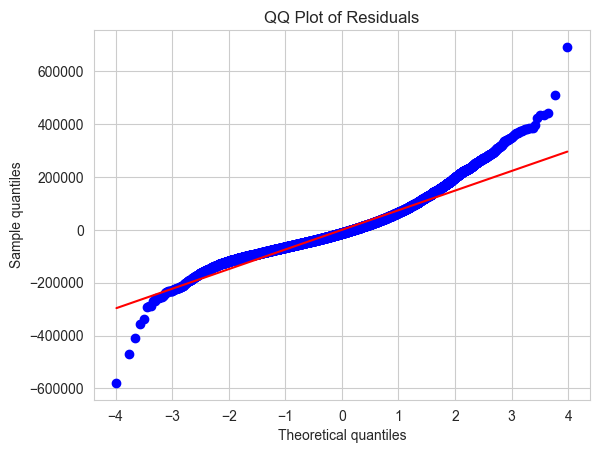

QQ plot shows that the residuals are not normally distributedas as there is significant deviation from the straight line
Shapiro-Wilk test statistic: 0.941179872829096
Shapiro-Wilk test p-value: 5.331800120616763e-66
Reject the null hypothesis: The residuals are not normally distributed


In [126]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()
print("QQ plot shows that the residuals are not normally distributedas as there is significant deviation from the straight line")

# perform shapiro-wilk test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("Shapiro-Wilk test p-value:", shapiro_test[1])
if shapiro_test[1] < 0.05:
    print("Reject the null hypothesis: The residuals are not normally distributed")
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed")

### Method 3 : Model 3 - Linear Regression

In [127]:
f3 = 'median_house_value ~ median_income + ocean_proximity'
model = sm.formula.ols(formula=f3, data=df)
result = model.fit()
r3 = result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     9284.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:57:20   Log-Likelihood:            -2.6055e+05
No. Observations:               20432   AIC:                         5.211e+05
Df Residuals:                   20429   BIC:                         5.211e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.944e+04   1446.897     

In [128]:
features_r3 = ['median_income', 'ocean_proximity']
X_r3 = df[features_r3]
vif_data_r3 = pd.DataFrame()
vif_data_r3["Feature"] = X_r3.columns
vif_data_r3["VIF"] = [variance_inflation_factor(X_r3.values, i) for i in range(len(X_r3.columns))]
print(vif_data_r3)

           Feature       VIF
0    median_income  1.533248
1  ocean_proximity  1.533248


Based on the Variance Inflation Factor (VIF) results:

- **median_income VIF:** 1.533248
- **ocean_proximity VIF:** 1.533248

These VIF values suggest that there is low multicollinearity between `median_income` and `ocean_proximity` in the model. Therefore, the coefficient estimates for these features are likely to be stable and reliable.


### Check for homodatasticity

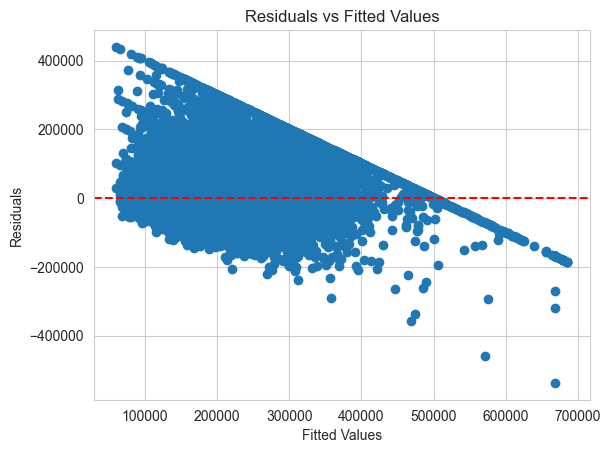

In [129]:
my_resid = result.resid
my_fitted = result.fittedvalues

# Create scatter plot
plt.scatter(my_fitted, my_resid)
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

#### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

In [130]:
residuals = result.resid
X = result.model.exog
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
print("Lagrange multiplier statistic:", lm)
print("p-value for Lagrange multiplier test:", lm_p_value)
print("F-statistic:", fvalue)
print("p-value for F-statistic:", f_p_value)
if f_p_value < 0.05:
    print("Reject the null hypothesis: The residuals are heteroscedastic")
else:
    print("Fail to reject the null hypothesis: The residuals are homoscedastic")

Lagrange multiplier statistic: 226.94422753778065
p-value for Lagrange multiplier test: 5.244295323706217e-50
F-statistic: 114.72979032030526
p-value for F-statistic: 2.826404299850481e-50
Reject the null hypothesis: The residuals are heteroscedastic


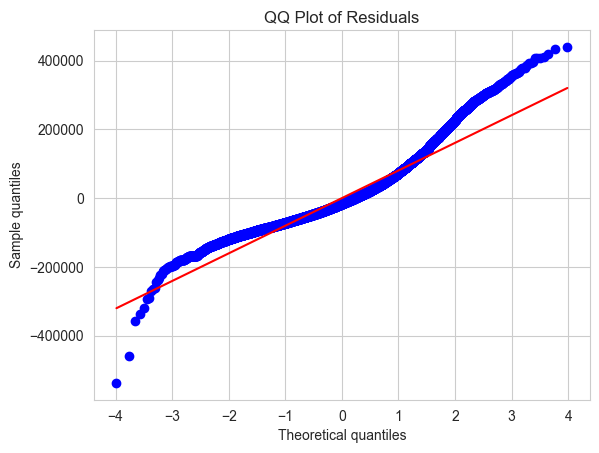

The QQ plot shows that residuals are not normally distributed
Shapiro-Wilk test statistic: 0.9249839879740915
Shapiro-Wilk test p-value: 4.876310866982817e-71
Reject the null hypothesis: The residuals are not normally distributed


In [131]:
import scipy.stats as stats
residuals = result.resid
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Sample quantiles")
plt.show()
print("The QQ plot shows that residuals are not normally distributed")

# perform shapiro-wilk test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("Shapiro-Wilk test p-value:", shapiro_test[1])
if shapiro_test[1] < 0.05:
    print("Reject the null hypothesis: The residuals are not normally distributed")
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed")

### Method - 4: Multiple Linear Regression

The mean squared error is:  4836361368.241866


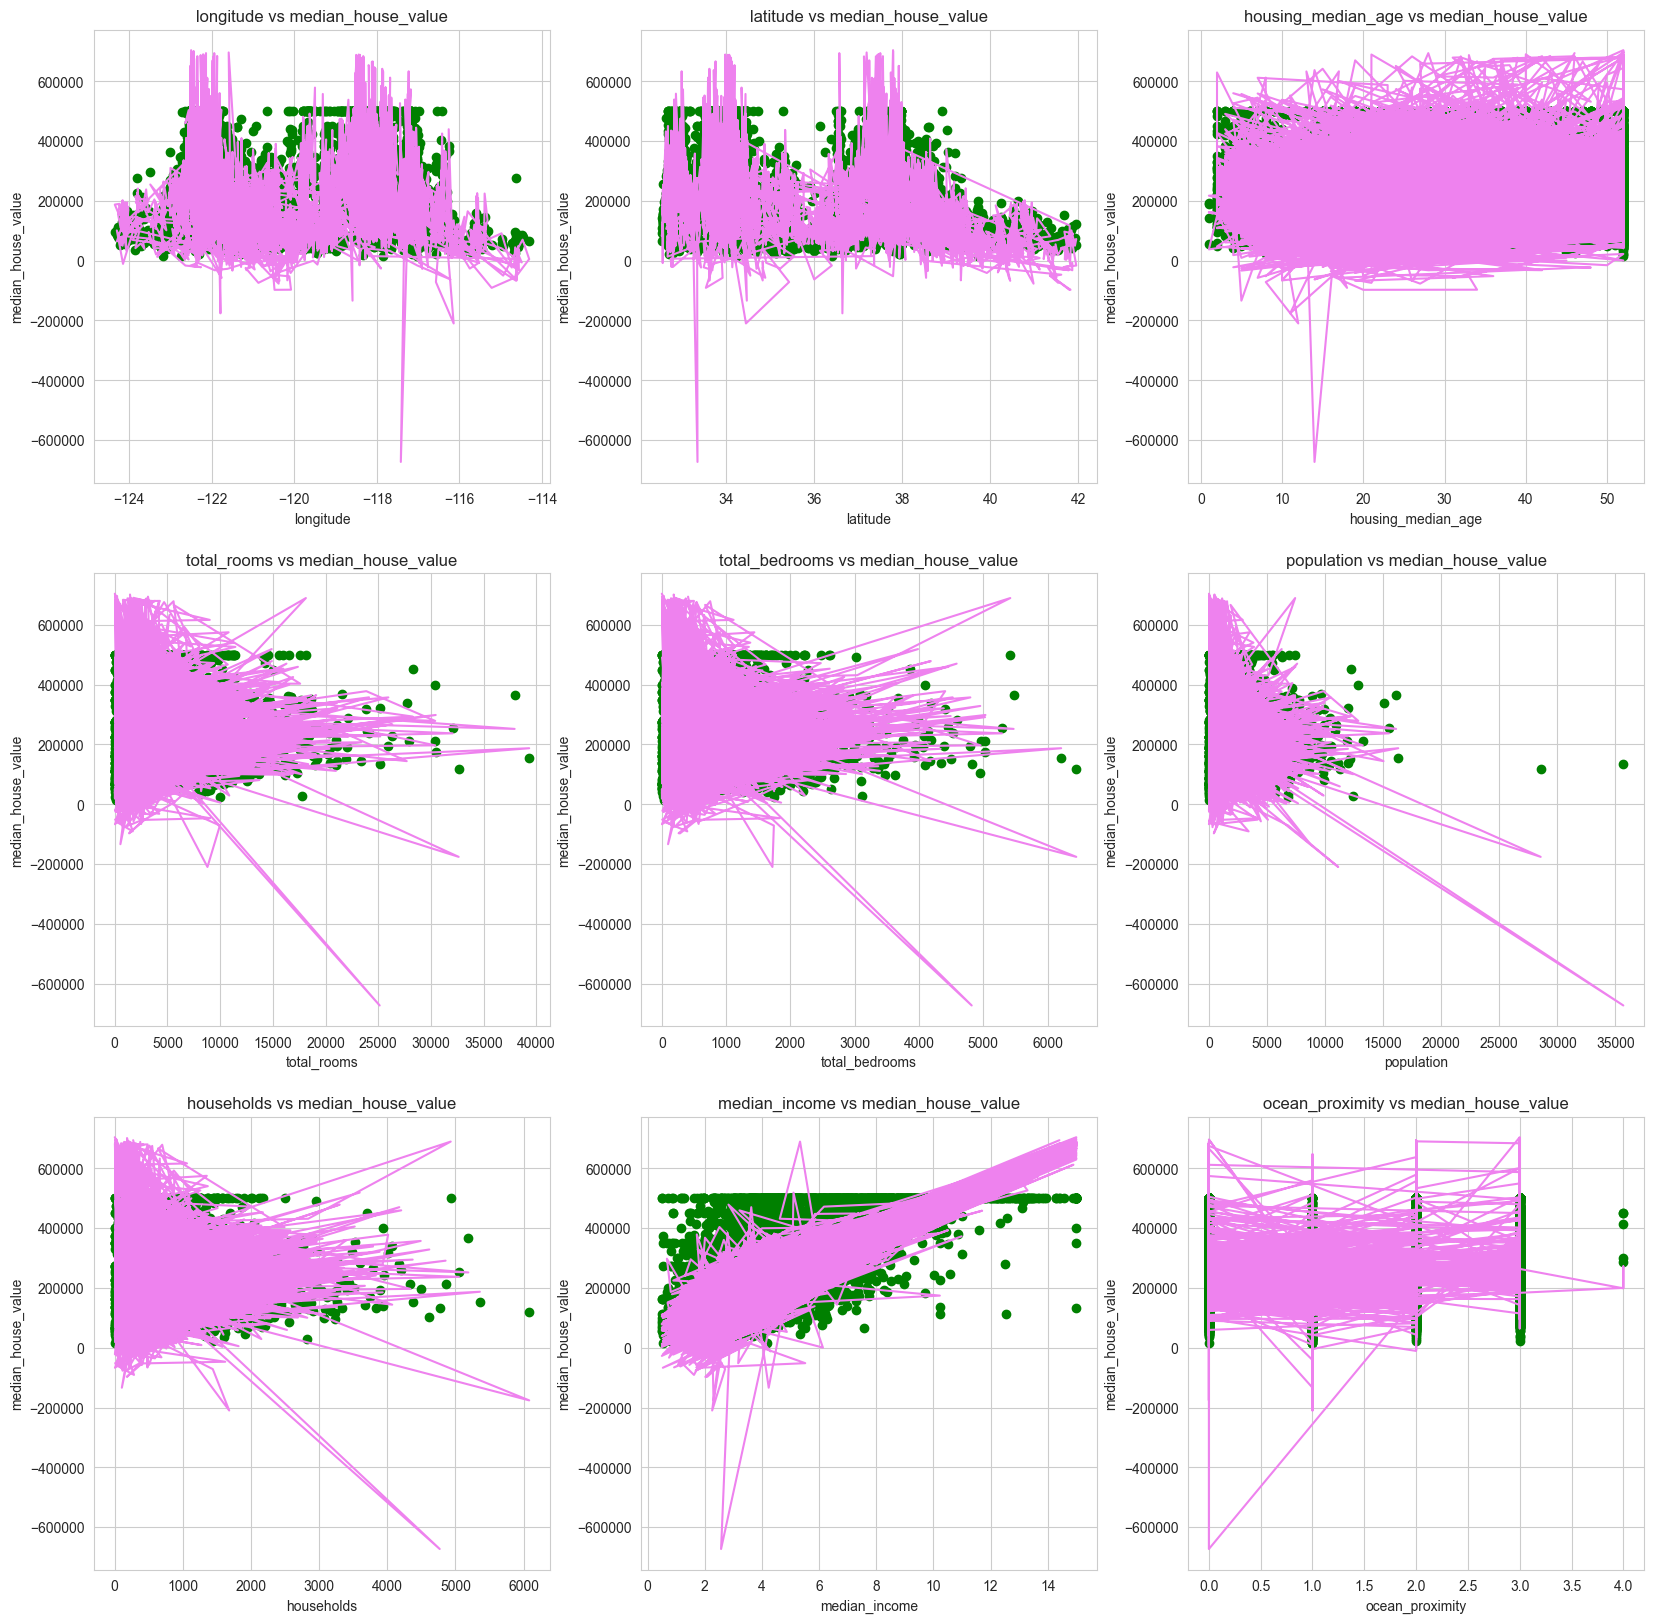

In [132]:
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

mse = mean_squared_error(y_pred, y)
print("The mean squared error is: ", mse)

plt.figure(figsize=(20, 20))
for i in range(0, len(df_2.columns)):
    plt.subplot(3, 3, i+1)
    plt.scatter(df_2.iloc[:, i], y, color='green')
    plt.plot(df_2.iloc[:, i], y_pred, color='violet')
    plt.xlabel(df_2.columns[i])
    plt.ylabel('median_house_value')
    plt.title(df_2.columns[i]+' vs median_house_value')

### Check for Homoscedasticity

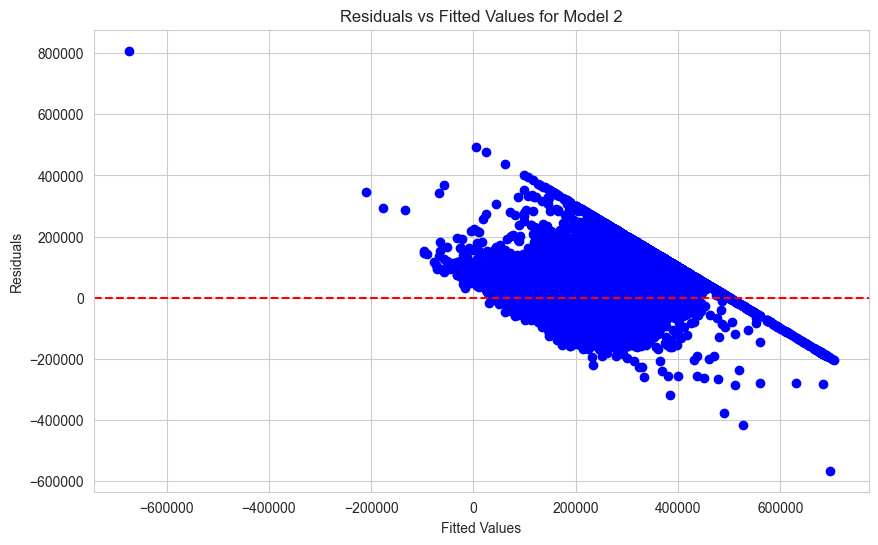

In [133]:
residuals = y - y_pred
mse = mean_squared_error(y_pred, y)

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')  # Add a red line at y=0
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values for Model 2')
plt.show()

In [134]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = df_2.columns
vif_data["VIF"] = [variance_inflation_factor(df_2.values, i) for i in range(len(df_2.columns))]

In [135]:
X = df_2
for i in range(0,5):
    max_vif_index = vif_data['VIF'].idxmax()
    X = X.drop(vif_data['feature'][max_vif_index], axis=1)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
df_vif = X
print("The final values are as follows: ")
print(vif_data)

The final values are as follows: 
              feature       VIF
0  housing_median_age  3.343390
1          population  2.060318
2       median_income  3.398675
3     ocean_proximity  1.803963


##### VIF is used to check multicollinearity, so if VIF is above 5 then it indicates high multicollinearity

##### Overall, the VIF values indicate that while there is some degree of collinearity among the predictors, it is not severe enough to cause significant multicollinearity issues.

##### The variables "population" and "ocean_proximity" have relatively low VIF values, suggesting they are less correlated with other predictors in the model.

##### The variables "housing_median_age" and "median_income" have slightly higher VIF values, indicating a moderate degree of collinearity, but it's still within an acceptable range.

##### These results suggest that the selected predictors may be suitable for inclusion in a linear regression model without significant multicollinearity concerns. However, it's always important to consider the context of the analysis and interpret the results accordingly.

##### We get the conclusion that there is no constant variance despite the fact that constant variance is supposed to be necessary for regression because of the uneven distribution of the residuals. Consequently, heteroscedasticity exists. 

In [136]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
X_with_const = sm.add_constant(X)
ncv_test_result = het_breuschpagan(residuals, X_with_const,robust='hc1')
p_value_ncv_test = ncv_test_result[1]
print("The p-value of the Breusch-Pagan test with sandwich estimator is: ", p_value_ncv_test)

The p-value of the Breusch-Pagan test with sandwich estimator is:  2.0758043938158592e-71


Since the p-value for each test is less than 0.05, we may say that the data are heteroscedastic.

##### Since the p-value is much smaller than any reasonable significance level (e.g., 0.05), we reject the null hypothesis of homoscedasticity. Therefore, we conclude that there is strong evidence of heteroscedasticity in the residuals of the linear regression model.

##### Implications: Heteroscedasticity violates one of the assumptions of linear regression, which is that the residuals should have constant variance. In the presence of heteroscedasticity, the standard errors of the estimated coefficients may be biased, leading to incorrect inferences about the statistical significance of the regression coefficients.

QQ plot for Model 5: 


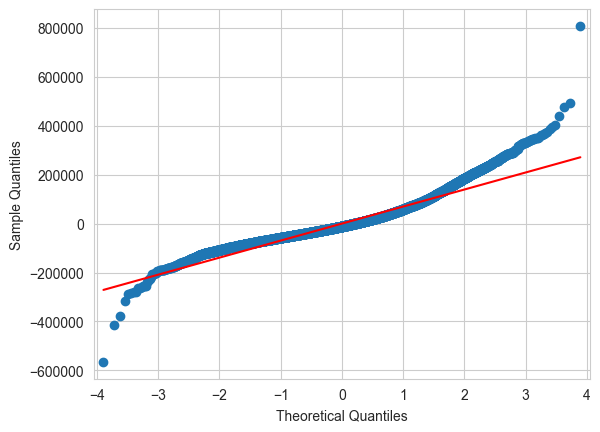

Shapiro-Wilk test statistic: 0.9274477240872653
Shapiro-Wilk test p-value: 2.461421028399279e-70
Reject the null hypothesis: The residuals are not normally distributed


In [137]:
print("QQ plot for Model 5: ")
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred
sm.qqplot(residuals, line='s')
plt.show()

# perform shapiro-wilk test
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test statistic:", shapiro_test[0])
print("Shapiro-Wilk test p-value:", shapiro_test[1])
if shapiro_test[1] < 0.05:
    print("Reject the null hypothesis: The residuals are not normally distributed")
else:
    print("Fail to reject the null hypothesis: The residuals are normally distributed")

#### Since plot of residuals against fitted values is not constant, it means that there is heteroscedasticity in our data

As indicated by Q-Q plot, the residuals are not normally distributed

In [138]:
import statsmodels.api as sm

print("AIC for Model 1: ",r1.aic)
print("AIC for Model 2: ",r2.aic)
print("AIC for Model 3: ",r3.aic)
X = df_2
y = df['median_house_value']
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)
residuals = y - y_pred
X = df_2
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("AIC for Model 4: ", model.aic)

AIC for Model 1:  518540.5143453952
AIC for Model 2:  517556.58000400197
AIC for Model 3:  521109.3809723644
AIC for Model 4:  513625.4271596733


### Model 2 has a lower AIC and hence performs better 

In [139]:
f2 = 'median_house_value ~ latitude + housing_median_age + total_bedrooms + population + median_income + ocean_proximity'
model = sm.formula.ols(formula=f2, data=df)
result = model.fit()
r2 = result
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     4331.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:57:25   Log-Likelihood:            -2.5877e+05
No. Observations:               20432   AIC:                         5.176e+05
Df Residuals:                   20425   BIC:                         5.176e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.898e+05   1.01

In [140]:
print("Confidence intervals for Model 2: 95% confidence level")
print(result.conf_int())

Confidence intervals for Model 2: 95% confidence level
                                0              1
Intercept           169995.468598  209638.958335
latitude             -6838.340789   -5759.743096
housing_median_age    1914.870492    2094.901938
total_bedrooms         108.037464     118.628510
population             -36.227501     -32.316063
median_income        42688.804574   43807.905678
ocean_proximity       3846.377043    6160.437802


**Summary of Regression Analysis:**

- **R-squared:** 0.560, indicating the model explains approximately 56.0% of the variation in the response variable.
- **Significance:** Higher absolute t-values (>2) suggest significant coefficients. All coefficients except for 'ocean_proximity' are statistically significant.
- **Adjusted R-squared:** Consistent with R-squared at 0.560.
- **Model Fit:** F-statistic of 4331 with p-value 0.00 suggests a highly significant overall model fit.
- **Interpretations:** Notable coefficients include 'latitude' ($-6299.04), 'housing_median_age' ($2004.89), 'total_bedrooms' ($113.33), 'population' ($-34.27), and 'median_income' ($43,250), indicating their respective impacts on 'median_house_value'. 'ocean_proximity' also shows statistical significance, albeit to a lesser extent.

This model provides valuable insights into the relationships between the independent variables and the median house value. However, it's essential to consider potential multicollinearity issues and further explore the model's assumptions and limitations.


# Question 2

In [141]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [142]:
data = pd.read_csv('binary.csv')
data = data.dropna()
# min-max scaling is not necessary for logistic regression
X = data[['gre', 'gpa', 'rank']]
y = data['admit']

In [143]:
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print("Parameters:")
print(result.params)
print("\nSummary:")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.565088
         Iterations 6
Parameters:
const   -3.400466
gre      0.001725
gpa      0.891067
rank    -0.615949
dtype: float64

Summary:
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  320
Model:                          Logit   Df Residuals:                      316
Method:                           MLE   Df Model:                            3
Date:                Thu, 11 Apr 2024   Pseudo R-squ.:                 0.09016
Time:                        18:57:25   Log-Likelihood:                -180.83
converged:                       True   LL-Null:                       -198.75
Covariance Type:            nonrobust   LLR p-value:                 8.100e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

## Statistics and Interpretation:

**Pseudo R-squared:** The Pseudo R-squared value is 0.09016. This value represents the proportion of variance explained by the model. A higher value indicates a better fit of the model to the data.

**Coefficients:**

- **GRE:** The coefficient for GRE is 0.0017. This indicates that for a one-unit increase in GRE score, the log-odds of being admitted increases by 0.0017, holding other variables constant.
- **GPA:** The coefficient for GPA is 0.8911. This indicates that for a one-unit increase in GPA, the log-odds of being admitted increases by 0.8911, holding other variables constant.
- **Rank:** The coefficient for rank is -0.6159. This indicates that for a one-unit increase in rank (i.e., higher rank), the log-odds of being admitted decreases by 0.6159, holding other variables constant.

**Significance:**

- The coefficient for GRE has a p-value of 0.158, which is greater than the typical significance level of 0.05. Therefore, GRE may not be statistically significant in predicting admission at this significance level.
- The coefficient for GPA has a p-value of 0.016, which is less than 0.05. Therefore, GPA is statistically significant in predicting admission at the 0.05 significance level.
- The coefficient for rank has a p-value of <0.001, indicating that it is highly statistically significant in predicting admission.

## Interpretation of Results:

The most significant variable that predicts whether someone will get admitted is the rank of the undergraduate institution, as it has the lowest p-value (<0.001).

In summary, according to this logistic regression model, GPA and the rank of the undergraduate institution are significant predictors of admission, while GRE may not be statistically significant in this context.




#### Both GPA and Rank are more significant variables for predicting the chance of admission. The p-values for both variables are less than 0.05, indicating a significant relationship with the response variable. The coefficients for both variables are positive, suggesting that higher GPA and Rank are associated with a higher chance of admission.

##### The most significant variable that predicts whether someone will get admitted is the rank of the undergraduate institution, as it has the lowest p-value (<0.001).

In [144]:
print("Confidence Intervals with 95% confidence level:")
conf_intervals = result.conf_int()
for i in range(len(conf_intervals)):
    print(f"Variable: {conf_intervals.index[i]}, Confidence Interval: {tuple(conf_intervals.iloc[i])}")

Confidence Intervals with 95% confidence level:
Variable: const, Confidence Interval: (-5.925518269248789, -0.8754146079120262)
Variable: gre, Confidence Interval: (-0.0006707634583183314, 0.0041209017978231875)
Variable: gpa, Confidence Interval: (0.16371746162548495, 1.6184156274951733)
Variable: rank, Confidence Interval: (-0.8964668167752332, -0.3354321184430738)


In [145]:
print("Odds ratios:")
print(np.exp(result.params))

Odds ratios:
const    0.033358
gre      1.001727
gpa      2.437728
rank     0.540128
dtype: float64


**Interpretation of Odds Ratios:**

- **GRE:** For each one-unit increase in GRE score, the odds of being admitted increase by approximately 1.0017 times, holding other variables constant.
- **GPA:** For each one-unit increase in GPA, the odds of being admitted increase by approximately 2.4377 times, holding other variables constant.
- **Rank:** For each one-unit increase in rank (i.e., higher rank), the odds of being admitted decrease by approximately 0.5401 times, holding other variables constant.
- **Constant (Intercept):** The odds of being admitted when all other variables are zero is approximately 0.0334.


In [146]:
y_pred = result.predict(X_test)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

Confusion Matrix:
[[49  4]
 [23  4]]
Accuracy: 0.6625


## Testing Interaction Effect

In [147]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

data['gpa_rank_interaction'] = data['gpa']*data['rank']
X = data[['gre', 'gpa', 'rank', 'gpa_rank_interaction']]
y = data['admit']
X = sm.add_constant(X)
X['gpa_rank_interaction'] = X['gpa']*X['rank']
y = data['admit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()
print("Parameters:")
print(result.params)

Optimization terminated successfully.
         Current function value: 0.565088
         Iterations 6
Parameters:
const                  -3.343342
gre                     0.001724
gpa                     0.874755
rank                   -0.641493
gpa_rank_interaction    0.007380
dtype: float64


In [148]:
print("\nSummary:")
print(result.summary())


Summary:
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  320
Model:                          Logit   Df Residuals:                      315
Method:                           MLE   Df Model:                            4
Date:                Thu, 11 Apr 2024   Pseudo R-squ.:                 0.09016
Time:                        18:57:25   Log-Likelihood:                -180.83
converged:                       True   LL-Null:                       -198.75
Covariance Type:            nonrobust   LLR p-value:                 3.123e-07
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.3433      3.375     -0.991      0.322      -9.958       3.271
gre                      0.0017      0.001      1.409      0.159      -0.001       0.004
gp

**Interaction Effect in the Logit Regression Model**

The model includes an interaction term (`gpa_rank_interaction`) to assess whether the effect of GPA on admission likelihood depends on a student's rank.

* **Coefficient:** 0.0074
* **Statistical Significance:** The p-value of the interaction term is 0.985, indicating that the interaction effect is not statistically significant.

**Interpretation:**

We don't have enough evidence to conclude that the relationship between GPA and the probability of admission is different for students of varying ranks. 

1. Coefficient of gpa_rank is in between gpa and rank.
2. The influence of gpa on the likelihood of admission varies depending on rank.
For example, the influence of gpa on the chance of admission varies depending on rank.

In [149]:
y_pred = result.predict(X_test)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

Confusion Matrix:
[[49  4]
 [23  4]]
Accuracy: 0.6625


In [150]:
data_train = data.copy()
data_train['gpa_rank_interaction'] = data_train['gpa']*data_train['rank']
data_train2 , data_test2 = train_test_split(data_train, test_size=0.2, random_state=42)
formula_interaction = 'admit ~ gre + gpa + rank + gpa_rank_interaction'
l_interaction = sm.formula.glm(formula=formula_interaction, data=data_train2, family=sm.families.Binomial()).fit()
y_pred = l_interaction.predict(data_test2)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]
accuracy = accuracy_score(data_test2['admit'], y_pred_binary)
print("Accuracy:", accuracy)
print("Summary of Logistic Regression Model with Interaction Term:")
print(l_interaction.summary())

Accuracy: 0.6625
Summary of Logistic Regression Model with Interaction Term:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  admit   No. Observations:                  320
Model:                            GLM   Df Residuals:                      315
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -180.83
Date:                Thu, 11 Apr 2024   Deviance:                       361.66
Time:                        18:57:25   Pearson chi2:                     321.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1060
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

Based on the provided data, the logistic regression model with the interaction term does not show significant improvement in predictive performance:

- **Accuracy:** The accuracy of the model is 0.6625, indicating that it correctly predicts admission status for approximately 66.25% of the observations.

- **Interpretation of Coefficients:** 
  - The coefficient for the interaction term `gpa_rank_interaction` is 0.0074, with a p-value of 0.985, suggesting that the interaction between GPA and rank is not statistically significant. Thus, it does not substantially affect the prediction of admission status.

- **Model Fit:** 
  - The pseudo R-squared value is 0.1060, indicating that the model explains about 10.60% of the variation in the response variable. While this suggests some degree of fit, the improvement over the model without the interaction term is relatively modest.

In conclusion, while the logistic regression model with the interaction term achieves a reasonable accuracy and explains some variation in the response variable, the interaction between GPA and rank does not significantly enhance its predictive capability in determining admission status. Further investigation may be necessary to uncover more nuanced relationships between predictors and the response variable.
